In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models.efficientnet import *

In [2]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [3]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

src = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        )

src

LabelLists;

Train: LabelList (5232 items)
x: ImageList
Image (3, 1229, 1574),Image (3, 824, 1088),Image (3, 1124, 1462),Image (3, 1677, 1936),Image (3, 1600, 1626)
y: CategoryList
normal,normal,normal,normal,normal
Path: /media/sm2/data/pneumonia/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 1764, 2093),Image (3, 1818, 2053),Image (3, 2296, 2496),Image (3, 917, 1340),Image (3, 2458, 2720)
y: CategoryList
normal,normal,normal,normal,normal
Path: /media/sm2/data/pneumonia/chest_xray;

Test: None

In [4]:
def get_data(bs, sz):
    return (src.transform(get_transforms(), size=sz)
            .databunch(bs=bs)
            .normalize(stats)
            )

data = get_data(64, 456)
data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b5')
model

Loaded pretrained weights for efficientnet-b5


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [6]:
model._fc = nn.Linear(2048, 3)

In [7]:
learn = Learner(data, 
                model,
                bn_wd=False,
                metrics=error_rate,
                loss_func=LabelSmoothingCrossEntropy(),
                callback_fns=[BnFreeze,
                              partial(SaveModelCallback, monitor='error_rate', name='best_error')
                             ],
               ).to_fp16()

In [8]:
learn.split(lambda m: (model._conv_head,))
learn.load('384', purge=True);

In [9]:
learn.to_fp16()
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.604694,0.586765,0.147436,02:09
1,0.612738,0.588632,0.144231,02:06
2,0.597709,0.562166,0.126603,02:04
3,0.581879,0.571946,0.129808,02:06
4,0.562112,0.577788,0.139423,02:07


Better model found at epoch 0 with error_rate value: 0.14743590354919434.
Better model found at epoch 1 with error_rate value: 0.14423076808452606.
Better model found at epoch 2 with error_rate value: 0.12660256028175354.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.92E-07


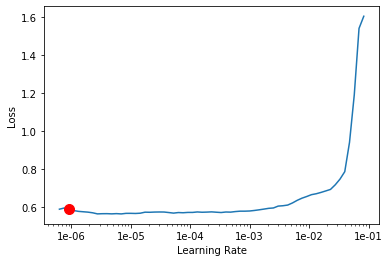

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
lr = 1e-5
learn.fit_one_cycle(5, slice(lr/40, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.574164,0.566398,0.125000,02:32
1,0.574808,0.570978,0.128205,02:32
2,0.573661,0.573976,0.129808,02:34
3,0.573621,0.575047,0.134615,02:35
4,0.569487,0.574533,0.133013,02:33


Better model found at epoch 0 with error_rate value: 0.125.


In [12]:
learn.save('456')

In [13]:
learn.load('456', purge=True)
data = get_data(32, 512)
learn.data = data

In [14]:
learn.to_fp16()
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.607122,0.616360,0.155449,02:30
1,0.618567,0.581899,0.137821,02:33
2,0.619774,0.600403,0.136218,02:34
3,0.574681,0.579742,0.136218,02:34
4,0.559726,0.577588,0.141026,02:31


Better model found at epoch 0 with error_rate value: 0.15544871985912323.
Better model found at epoch 1 with error_rate value: 0.1378205120563507.
Better model found at epoch 2 with error_rate value: 0.13621795177459717.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-05


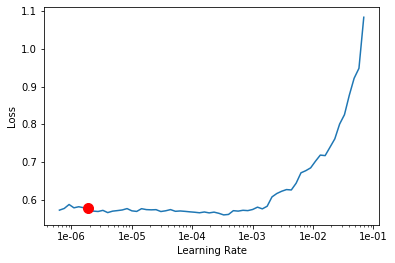

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
lr = 3.31e-5
learn.fit_one_cycle(5, slice(lr/40, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.577234,0.603724,0.142628,03:15
1,0.572572,0.591613,0.134615,03:13
2,0.566013,0.586380,0.133013,03:14
3,0.569618,0.586993,0.134615,03:11
4,0.557096,0.584153,0.134615,03:13


Better model found at epoch 0 with error_rate value: 0.14262820780277252.
Better model found at epoch 1 with error_rate value: 0.13461539149284363.
Better model found at epoch 2 with error_rate value: 0.1330128163099289.


In [17]:
learn.save('512')